# In this notebook, it will contain various multiple comparsion correction

#### Threshold image without correction

In [9]:
from nilearn.image import load_img
from nilearn.glm import threshold_stats_img


z_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/group_203/hp_all/thr_alignPhi_even_zmap.nii.gz')
thresholded_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.5,
    height_control='fpr',
    cluster_threshold=100,
    two_sided=False,
)
print('The fpr threshold is %.3g' % threshold)
thresholded_map.to_filename(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/group_203/hp_all/alignPhi_even_zmap_thr2.3.nii.gz')

The fpr threshold is 0


#### FDR correction

In [ ]:
from nilearn.image import load_img
from nilearn.glm import threshold_stats_img

z_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/group_203/age_all/rsa_ztransf_img_coarse_6fold_Age_zmap.nii.gz')
fdr_thresholded_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR threshold is %.3g' % threshold)
fdr_thresholded_map.to_filename(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/group_203/age_all/rsa_ztransf_img_coarse_6fold_Age_zmap_thr-fdr.nii.gz')

#### FWE correction

In [ ]:
from nilearn.image import load_img
from nilearn.glm import threshold_stats_img

z_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/group_203/acc/M2_corrxdistance_acc_zmap.nii.gz')
mask = load_img(r'/mnt/workdir/DCM/result/ROI/anat/cortex/hippocampus/HC_resampled.nii.gz')
fwe_thresholded_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni',mask_img=mask)
print('The Bonferroni-corrected threshold is %.3g' % threshold)
fwe_thresholded_map.to_filename('/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/group_203/acc/M2_corrxdistance_acc_zmap_fwe05.nii.gz')

#### Cluster size inference

In [ ]:
#### Cluster size thresholding
from nilearn.image import load_img
from nilearn.glm import cluster_level_inference

z_map = load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/Setall/6fold/group_old/mean/hexagon_tmap.nii.gz')
#mask = load_img(r'')
proportion_true_discoveries_img = cluster_level_inference(
    z_map, threshold=3.1, alpha=.05)
    #,mask_img=mask)
proportion_true_discoveries_img.to_filename(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/Setall/6fold/group_old/mean/hexagon_tmap_thr-clc0.05.nii.gz')

#### Non_parametric_inference - voxel level correction

In [3]:
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image import load_img,binarize_img,threshold_img
from nilearn.glm.second_level import non_parametric_inference
from nilearn.glm.second_level import make_second_level_design_matrix

task= 'game1'
# subject
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query(f'{task}_fmri>=0.5')  # look out
#data = data.query("Age<18")
subjects = data['Participant_ID'].to_list()

zmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'

second_level_input = [zmap_template.format(s) for s in subjects]

# Set design matrix
if task == 'game1':
    accuracy = data['game1_acc'].to_list()
elif task == 'game2':
    accuracy = data['game2_test_acc'].to_list()
else:
    raise Exception("Task name is error!")
age = data['Age']
covariates = {'age': age,'acc':accuracy}
extra_info_subjects = pd.DataFrame(covariates)
extra_info_subjects['subject_label'] = subjects
design_matrix = make_second_level_design_matrix(subjects, extra_info_subjects)
covariate_name = covariates.keys()
for key in covariate_name:
    design_matrix[key] = design_matrix[key] - design_matrix[key].mean()

mask = load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
mask = binarize_img(mask,10)
#mask  = load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
#mask = binarize_img(mask,threshold=10)
out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=design_matrix,
    second_level_contrast='acc',
    model_intercept=True,
    n_perm=1000,  # Ideally, this should be 10,000.
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=50,
    #threshold=0.1,
    mask=mask,tfce=True)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


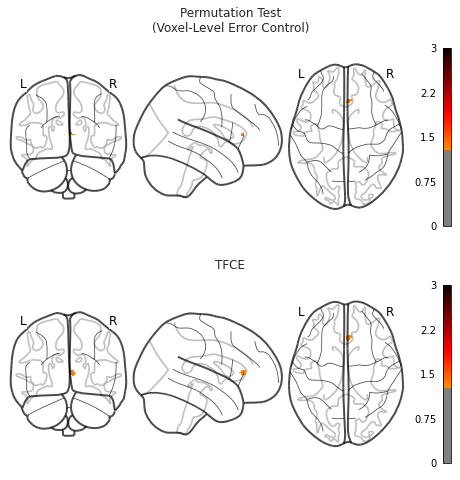

In [11]:
import numpy as np
threshold = - np.log10(0.05)  # p < 0.1
vmax = 3.69  # ~= -np.log10(1 / 500)

IMAGES = [
    out_dict['logp_max_t'],
    out_dict['logp_max_size'],
    out_dict['logp_max_mass'],
    out_dict['logp_max_tfce'],
]
TITLES = [
    'Permutation Test\n(Voxel-Level Error Control)',
    #'Permutation Test\n(Cluster-Size Error Control)',
    #'Permutation Test\n(Cluster-Mass Error Control)',
    'TFCE',
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
for i in range(2):
    ax = axes[i]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        vmax=3,
        display_mode='ortho',
        plot_abs=False,
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(TITLES[img_counter])
    img_counter += 1

plt.show()
out_dict['logp_max_t'].to_filename(r"/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/group/age_acc/hexagon_covary-acc_roi-EC_thr-svc.nii.gz")
out_dict['logp_max_tfce'].to_filename(r"/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/group/age_acc/hexagon_covary-acc_roi-EC_thr-tfce.nii.gz")

#### FSL cluster level correction

In [1]:
zmap = r'M2_corrxdistance_zmap.nii.gz'
# get dlh and volume for thresholding
smooth = 'smoothest -z {} -m /mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'

# Cluster-wise thresholding
# cluster = 'cluster -i {} -t 3.1 --othresh=thr_{} -o cluster_mask_zstat1 --connectivity=26 --mm --olmax=lmax_zstat1_std.txt --scalarname=Z -p 0.05 -d 0.00244744 --volume=235840'
dlh = 0.00385536
cluster = 'cluster -i {} -t 3.1 --othresh=thr_{} --connectivity=26 --mm -p 0.05 -d {} --volume=235840'
print(smooth.format(zmap))
print(cluster.format(zmap,zmap,dlh))

smoothest -z M2_corrxdistance_zmap.nii.gz -m /mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii
cluster -i M2_corrxdistance_zmap.nii.gz -t 3.1 --othresh=thr_M2_corrxdistance_zmap.nii.gz --connectivity=26 --mm -p 0.05 -d 0.00385536 --volume=235840


In [ ]:
# view image on surfer
from nilearn import image,plotting

img = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/group/mean/thr_M2_corrxdistance_zmap.nii.gz')
html_view = plotting.view_img_on_surf(img,surf_mesh='fsaverage5',threshold=3.1,symmetric_cmap=False)
html_view.open_in_browser()